# Machine Learning in Python - Project 1

Due Friday, March 6th by 5 pm.

Adrian Lee, Abu Mazhar, Elliot Kovanda, Gianluca Bianchi

## 0. Setup

In [1]:
# Install required packages
!pip install -q -r requirements.txt

In [2]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

import datetime

In [3]:
# Load data
d = pd.read_csv("the_office.csv")
#importing second more up to date dataframe
d2 = pd.read_csv("the_office_series.csv")

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

## 2. Exploratory Data Analysis and Feature Engineering

The `episode_name` and `EpisodeTitle` columns from the two data frames contained spelling errors and discrepancies that would have prevented subsequent merging of the data frames using these columns, including duplicate rows. Therefore these issues were first mitigated through data cleaning.

In [4]:
# data cleaning for episode names

# use lower case
d.episode_name = d.episode_name.apply(lambda x: x.lower())
d2.EpisodeTitle = d2.EpisodeTitle.apply(lambda x: x.lower())

# unify the spellings in the two data frames
d.episode_name = d.episode_name.str.replace('surveilance', 'surveillance', regex=False)
d.episode_name = d.episode_name.str.replace('cover', 'cover-up', regex=False)
d.episode_name = d.episode_name.str.replace('a.a.r.m', 'a.a.r.m.', regex=False)
d.episode_name = d.episode_name.str.replace(' (parts 1&2)', '', regex=False)
d2.EpisodeTitle = d2.EpisodeTitle.str.replace(': part 1', ' (part 1)', regex=False)
d2.EpisodeTitle = d2.EpisodeTitle.str.replace(': part 2', ' (part 2)', regex=False)
d.episode_name = d.episode_name.str.replace('&', 'and', regex=False)
d.episode_name = d.episode_name.str.replace('s*x', 'sex', regex=False)

# remove the word "the" from episode names
d.episode_name = d.episode_name.str.replace('the ', '', regex=False)
d2.EpisodeTitle = d2.EpisodeTitle.str.replace('the ', '', regex=False)

# merge the `about` column of episodes that contains two parts
d2.loc[d2.EpisodeTitle.str.contains('delivery (part 2)', regex=False),'About'] = ' '.join(d2[d2.EpisodeTitle.str.contains('delivery')]['About'])
d2.loc[d2.EpisodeTitle.str.contains('niagara (part 2)', regex=False),'About'] = ' '.join(d2[d2.EpisodeTitle.str.contains('niagara')]['About'])

# only keep rows for the second part
d2 = d2.loc[~d2.EpisodeTitle.str.contains('delivery (part 1)', regex=False)]
d2 = d2.loc[~d2.EpisodeTitle.str.contains('niagara (part 1)', regex=False)]

# remove "(part 2)" from the episode names
d2.loc[d2.EpisodeTitle.str.contains('delivery (part 2)', regex=False), "EpisodeTitle"] = 'delivery'
d2.loc[d2.EpisodeTitle.str.contains('niagara (part 2)', regex=False), "EpisodeTitle"] = 'niagara'

# check whether there are still differences in episode names
set(d.episode_name.tolist()).symmetric_difference(set(d2.EpisodeTitle.tolist()))

set()

Now that we have clean data, we merge the two data frames using the most up-to-date values for `imdb_rating` and `total_votes`.

In [5]:
# select columns of interest from the supplementary data frame
d2 = d2[["Ratings", "EpisodeTitle", "About", "Viewership", "Duration", "GuestStars", "Director"]]

# replace `imdb_rating` in the original dataframe with `Ratings` from the additional data frame, since the latter has a higher sample size
d.imdb_rating = d['episode_name'].map(d2.set_index('EpisodeTitle')['Ratings'])

# combine the two data frames using episode names
d = pd.merge(d, d2, left_on='episode_name', right_on='EpisodeTitle')

# drop `EpisodeTitle`
d = d.drop('EpisodeTitle', axis = 1)

### Feature Engineering: `n_lines`, `n_directions`, `n_words`, and `n_speak_char`

On inspection of the aforementioned variables we can see that they are correlated with one another. This is an issue since if we include all of them we may obtain an unstable model which perform suboptimally on test data. These correlations are shown in the pairplot below. The most highly correlated variables are those with the smallest confidence interval, in this case the 'n_lines' and 'n_words' variables. In order to account for this we introduce a new variable, `words_per_line`, which encapsulates both of these features whilst reducing the variation of our model.

The confidence intervals between all the other variables were very large in comparison. Therefore we subsequently decided that they were not correlated enough to be removed or altered.

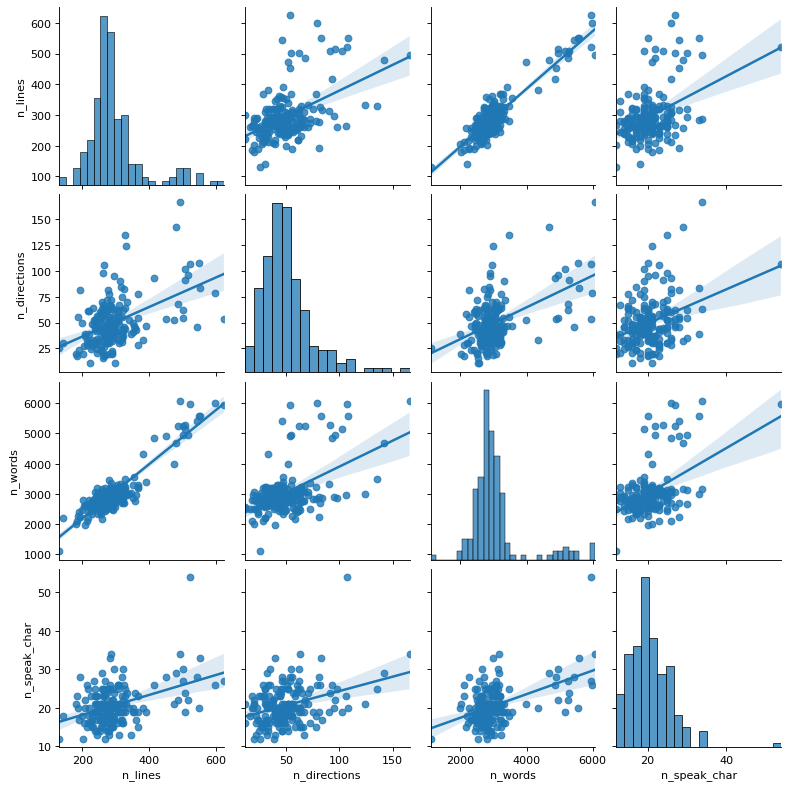

In [6]:
sns.pairplot(data=d,
            y_vars=["n_lines", "n_directions", "n_words", "n_speak_char"],
            x_vars=["n_lines", "n_directions", "n_words", "n_speak_char"],
            kind="reg");

In [7]:
# combine `n_words` and `n_lines` into one feature
d['words_per_line'] = d.n_words/d.n_lines

### Feature Engineering: `air_date`, `month`

To explore whether `imdb_ratings` were associated with the months in which episodes were released, the `air_date` was converted to a "date" format. Afterwards, the months could be extracted from the dates, so that the distributions of `imdb_ratings` for each month could be visualised.

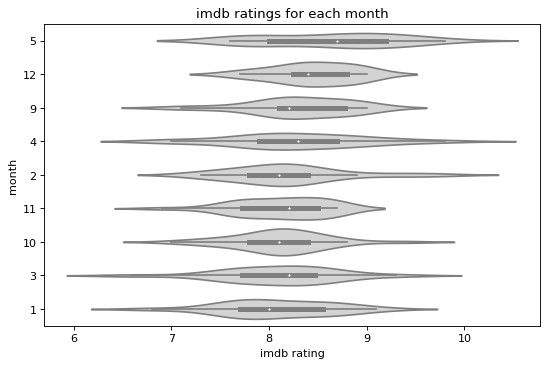

In [8]:
# transform `air_date` into a `date`
d.air_date = pd.to_datetime(d.air_date)

# extract month from `air_date`
d['month'] = pd.DatetimeIndex(d.air_date).month

# imdb ratings for each month
imdb_rating_month = {}

for month in d.month:
    imdb_rating_month[str(month)] = d.imdb_rating[d.month == month].tolist()

imdb_rating_month = pd.DataFrame.from_dict(imdb_rating_month, orient='index').transpose()

# rank violin plot by mean imdb for each `main_char`
months_imdb_ranked = pd.DataFrame({'months': imdb_rating_month.columns,
          'mean_imdb_rating': [mean for mean in np.mean(imdb_rating_month)]}).sort_values(by='mean_imdb_rating', ascending=False)['months'].tolist()

# melt data frame
imdb_rating_month_melted = imdb_rating_month.melt()

# create plot
sns.violinplot(y='variable', x='value', data=imdb_rating_month_melted, color='lightgrey',order=months_imdb_ranked);
plt.title('imdb ratings for each month');
plt.xlabel('imdb rating');
plt.ylabel('month');

### Feature Engineering: `GuestStars` and `main_chars`

The first issue we encountered with these columns was the fact that they were both object types containing strings, which we cannot directly use in our model. Therefore we changed `GuestStar` into a column of integer type which simply indicates the presence or absence of a guest star. We chose this as opposed to keeping the original names of the guest stars, since most guest stars only starred in one or two episodes, hence differentiating between them would not be of benefit.

In [9]:
# change GuestStars from names into whether each episode features a guest star (binary: yes/no)
d.loc[pd.notnull(d.GuestStars),"GuestStars"] = 1
d.loc[pd.isnull(d.GuestStars),"GuestStars"] = 0

d.GuestStars = d.GuestStars.astype('int64');

We repeated this process for the `main_char` variable so that each main character now has their own column indicating their presence in each episode.

In [10]:
# split `main_chars` column into multiple columns
main_chars_split = d.main_chars.str.split(expand=True, pat=';')

# find out the total number of episode each main character starred in
main_chars = pd.unique(main_chars_split.values.ravel('K'))
main_chars = main_chars[main_chars != None] # remove Nan's

for char in main_chars:
    d[char] = None
    
# one indicator variable for each `main_char`
for char in main_chars:
    for i in np.arange(0, len(d.main_chars), 1):
        if (char in d.main_chars[i]):
            d.at[i,char] = 1
        else:
            d.at[i,char] = 0

Upon analysis of the number of times each main character appeared in each episode we found that the impact of each appearance on the imdb rating was negligible. This is due to the fact that many of the characters may appeared in an episode but only briefly in comparison to others. In order to differentiate between the impact characters had on the imdb rating futher we considered the `About` column. This contained infomation about the plot and which characters were a key part of a given episode. Our idea was that if we found episodes about particular characters scored noticably higher or lower than the rest we could be certian that they were integral variables for our model.

The violin plot below shows the imdb rating by character. We can clearly see in the plot that episodes where in which 'Michael' is a key character score bertter than the rest, whilst ones where 'Erin' was mentioned more perform worse.

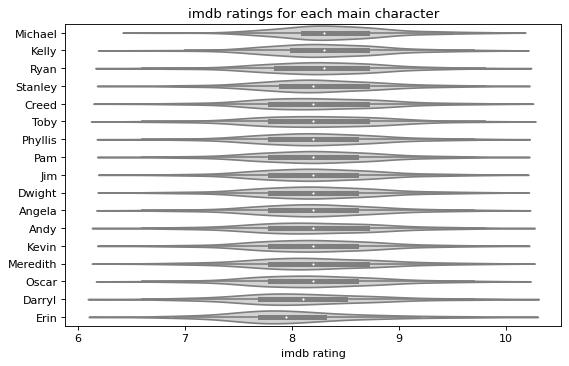

In [11]:
# count no. of occurences of each word in `About`

descriptions = str.split(' '.join(d.About))

descriptions_words_count = {}

# initialise dictionary
for word in descriptions:
    descriptions_words_count[word] = 0 

# count
for word in descriptions:
    descriptions_words_count[word] += 1
    
# count no. of occurences of each `main_chars` in `About`
descriptions_words_count = pd.Series(descriptions_words_count)

# imdb ratings for each main character
imdb_rating_char = {}

for char in main_chars:
    imdb_rating_char[char] = d.imdb_rating[d.main_chars.str.contains(char)].tolist()
imdb_rating_char = pd.DataFrame.from_dict(imdb_rating_char, orient='index').transpose()
# rank violin plot by mean imdb for each `main_char`
main_chars_imdb_ranked = pd.DataFrame({'names': imdb_rating_char.columns,
          'mean_imdb_rating': [mean for mean in np.mean(imdb_rating_char)]}).sort_values(by='mean_imdb_rating', ascending=False)['names'].tolist()

# melt data frame
imdb_rating_char_melted = imdb_rating_char.melt()

# create plot
sns.violinplot(y='variable', x='value', data=imdb_rating_char_melted, color='lightgrey',order=main_chars_imdb_ranked);
plt.title('imdb ratings for each main character');
plt.xlabel('imdb rating');
plt.ylabel('');

We then explored whether there were any statistically significant correlations between the number of mentions of each character in the `About` column with the `imdb_rating`, using the pairplot below. Columns that did not show statistically significant correlations were removed - correlations were deemed statistically significant when no horizontal line could be fit within the 95% convidence interval as indicated by the light blue shading around the regression line. Note that the pairplot below only shows columns with statistically significant correlations due to space constraint. 

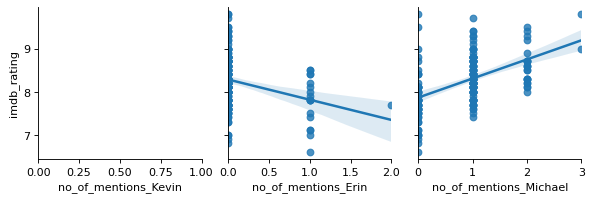

In [12]:
for char in main_chars:
    d[str('no_of_mentions_' + char)] = 0
    
# count the number of occurences of the names of each of the top 5 characters in 'About' 
for i in np.arange(0,len(d.About),1):
    for char in main_chars:
        if char in d.About[i]:
            d.at[i,str('no_of_mentions_' + char)] = d.About[i].count(char)  

sns.pairplot(data=d,
            y_vars=['imdb_rating'],
            x_vars=['no_of_mentions_Kevin',
            'no_of_mentions_Erin',
            'no_of_mentions_Michael'],
            kind='reg');

### Feature Engineering: `director` and `writer`

With directors we had an issue that we could not consider each director indivdually, due to the fact that there were so many which would make our model far more complex than it needed to be. On observing the data we found that there were directors who directed several episodes and some which only directed a single episode. In order to use this information to best help with our recommendation to NBC Univeral, whilst still keeping our model simple enough, we chose to split the directors into groups A,B,C and D. These correspond to directors who have written: 1 to 2, 3 to 6, 7 to 13 and 14 to 15 episodes respectively. 

In [13]:
# split `director` column into multiple columns
director_split = d.director.str.split(expand=True, pat=';')

directors = pd.unique(director_split.values.ravel('K'))
directors = directors[directors != None] # remove Nan's

# number of episodes each director took part in
director_count = [director_split[director_split==director].count().sum() for director in directors]
# create data frame with directors' names and number of episodes featured in
director_count = pd.DataFrame({'name': directors, 'count': director_count}).set_index('name')
# sort values
director_count = director_count.sort_values(by='count', ascending=False)

# take an average of episodes directed for episodes with more than one director
director_split_count = director_split

for director in director_count.index.tolist():
    director_split_count[director_split_count == director] = director_count.loc[director,"count"]
    
director_split_avg = np.mean(director_split_count,axis=1).astype('int')


# generate new column for the groups
d['director_grouped'] = 0

d.loc[(director_split_avg >= 1)&(director_split_avg <= 2), 'director_grouped'] = 'A'
d.loc[(director_split_avg >= 3)&(director_split_avg <= 6), 'director_grouped'] = 'B'
d.loc[(director_split_avg >= 7)&(director_split_avg <= 13), 'director_grouped'] = 'C'
d.loc[(director_split_avg >= 14)&(director_split_avg <= 15), 'director_grouped'] = 'D'

We repeated this process with the `writer` column, this time splitting into groups A,B,C,D and E,  respectively correspoding to: 1 to 4, 5 to 9, 10 to 13, 14 to 17 and 18 to 21 episodes written.

In [14]:
# split `writer` column into multiple columns
writer_split = d.writer.str.split(expand=True, pat=';')

writers = pd.unique(writer_split.values.ravel('K'))
writers = writers[writers != None] # remove Nan's

# number of episodes each writer took part in
writer_count = [writer_split[writer_split==writer].count().sum() for writer in writers]
# create data frame with writers' names and number of episodes featured in
writer_count = pd.DataFrame({'name': writers, 'count': writer_count}).set_index('name')
# sort values
writer_count = writer_count.sort_values(by='count', ascending=False)

# take an average of episodes written for episodes with more than one writer
writer_split_count = writer_split

for writer in writer_count.index.tolist():
    writer_split_count[writer_split_count == writer] = writer_count.loc[writer,"count"]
    
writer_split_avg = np.mean(writer_split_count,axis=1).astype('int')


# generate new column for the groups
d['writer_grouped'] = 0

d.loc[(writer_split_avg >= 1)&(writer_split_avg <= 4), 'writer_grouped'] = 'A'
d.loc[(writer_split_avg >= 5)&(writer_split_avg <= 9), 'writer_grouped'] = 'B'
d.loc[(writer_split_avg >= 10)&(writer_split_avg <= 13), 'writer_grouped'] = 'C'
d.loc[(writer_split_avg >= 14)&(writer_split_avg <= 17), 'writer_grouped'] = 'D'
d.loc[(writer_split_avg >= 18)&(writer_split_avg <= 21), 'writer_grouped'] = 'E'

### One-Hot Encoding and Final Inspection of the Data Frame

In [15]:
d = pd.get_dummies(d, columns = ['director_grouped', 'writer_grouped', 'month'])

In [16]:
# only keep columns that are of interest
d = d[['imdb_rating', 'total_votes', 'Viewership', 'Duration', 'GuestStars', 'words_per_line',
       'n_lines', 'n_directions', 'n_words', 'n_speak_char', 
   'no_of_mentions_Kevin', 'no_of_mentions_Erin', 'no_of_mentions_Michael',
   'director_grouped_A', 'director_grouped_B', 'director_grouped_C', 'director_grouped_D',
   'writer_grouped_A', 'writer_grouped_B', 'writer_grouped_C', 'writer_grouped_D', 'writer_grouped_E', 
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 
       'month_9', 'month_10', 'month_11', 'month_12']]

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.*

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

We were first able to explore a baseline linear regression model with all of the initial variables being kept. Performing GridSearchCV, we were able to get a cross validation rmse of ~0.55468. We then explored a Lasso model to optimize the $\alpha$ parameter and ended up with a cross validation rmse of ~0.5192. As expected this value was better than the Linear Regression model as it performed variable selection by shrinking many of the coefficients to 0. We also fit the data to a Ridge Regression model that resulted in a cross validation rmse of ~0.5186. Therefore, among the linear models the Ridge Regression model performed the best, however the final rmse of the model was clearly not very good. Also, taking into account the fits of the linear models and the fact the predictions were concentrated between 7.5 and 8.5 demonstrated that the models were not very accurate predictors for the tail ends of the data. As a result, we decided to proceed with a Decision Tree Regression model.

### Decision Tree Regressor

In [17]:
# import required libraries

import sklearn
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

We decided not to use `total_votes` and `Viewership` as predictor variables, since they are not under our control hence do not influence our recommendations. These columns were dropped from our dataset. The samples were then split into train and test sets. For the cross-validation, we only utilised the training set to prevent overfitting.

In [18]:
# drop columns that are not required, split samples into train and test sets
X = d.drop(['imdb_rating',"total_votes","Viewership"], axis=1)
y = d.imdb_rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Before training the decision tree model, the data were standardised to ensure that variables are of similar orders of magnitudes, so as to maximise the performance of the model. 

During cross-validation, we explored the effects of varying `max_depth` and `ccp_alpha`, which controls the maximum depth of the tree and the cost-complexity pruning of the tree to control the size of the tree and prevent overfitting. A standard five-fold cross validation approach was employed. The resulting optimised hyperparamters were then outputted from the model.

The best hyperparameters were found to be 

# ...

In [19]:
# Creating an StandardScaler object
std_scaler = StandardScaler()

# Creating a DecisionTreeRegressor object
dec_tree = tree.DecisionTreeRegressor()

# The pipeline standardises the data, then trains the decision tree regressor model.
pipe = Pipeline(steps=[('std_scaler', std_scaler),
                       ('dec_tree', dec_tree)])

# Creating lists of parameters to experiment with GridSearchCV, then inserting these into a dictionary
criterion = ['mse']
max_depth = list(range(10,31,1))
ccp_alpha = list(np.arange(0,0.05,0.005))

parameters = dict(dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth, 
                  dec_tree__ccp_alpha=ccp_alpha)

# KFold cross-validation specifications
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Creating a GridSearchCV object, using negative mean squared error as the metric
grid_search = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=kf)

# Run the grid_search object
grid_search.fit(X_train, y_train)

# Print the best parameters
print(grid_search.best_estimator_.get_params()['dec_tree'])
print('Best min_samples_split:', grid_search.best_estimator_.get_params()['dec_tree__min_samples_split'])
print('Best min_samples_leaf:', grid_search.best_estimator_.get_params()['dec_tree__min_samples_leaf'])
print("best index: ", grid_search.best_index_)
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)

DecisionTreeRegressor(ccp_alpha=0.015, max_depth=23)
Best min_samples_split: 2
Best min_samples_leaf: 1
best index:  76
best param:  {'dec_tree__ccp_alpha': 0.015, 'dec_tree__criterion': 'mse', 'dec_tree__max_depth': 23}
best score:  -0.24534650025370386


In [20]:
from sklearn.metrics import mean_squared_error

In [21]:
mean_squared_error(y_test, grid_search.predict(X_test), squared=False)

0.4172720294470545

A significant advantage of decision tree models over other models lies in its simple interpretation. In the diagram below, the resulting decision tree is visualised so that its decision-making process could be investigated.

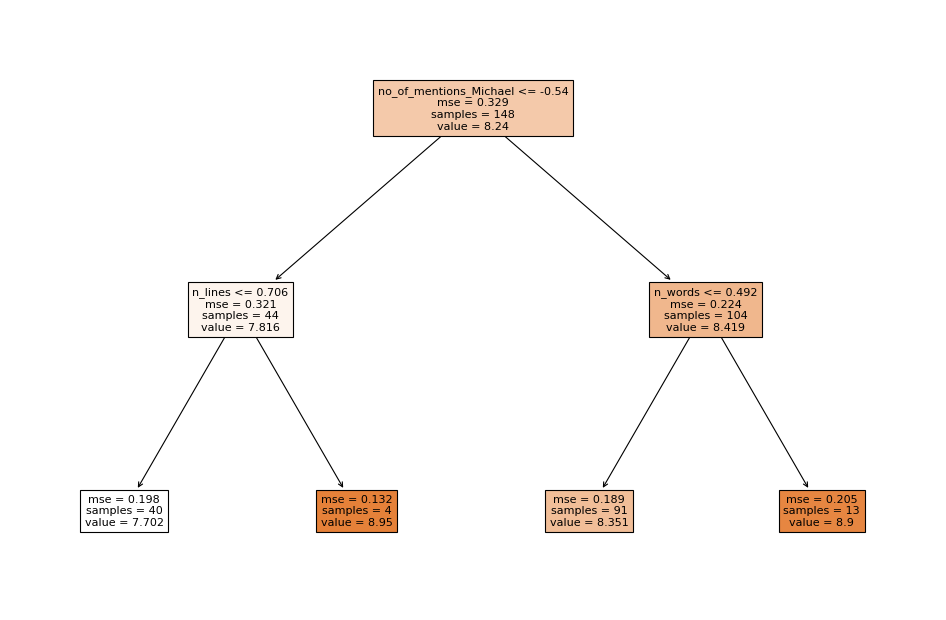

In [22]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(grid_search.best_estimator_.named_steps['dec_tree'], 
                   feature_names=X.columns,
                   filled=True, 
                   max_depth=5,
                   fontsize=10)

## Bootstrapping

In [70]:
from sklearn import utils
import statistics

In [37]:
X_boot = X_train
X_boot["imdb_rating"] = y_train
X_boot

C:\Users\Ellio\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Duration,GuestStars,words_per_line,n_lines,n_directions,n_words,n_speak_char,no_of_mentions_Kevin,no_of_mentions_Erin,no_of_mentions_Michael,...,month_1,month_2,month_3,month_4,month_5,month_9,month_10,month_11,month_12,imdb_rating
139,23,0,11.544248,226,31,2609,16,0,0,0,...,0,0,0,0,0,1,0,0,0,8.1
8,22,1,9.266904,281,33,2604,14,0,0,1,...,0,0,0,0,0,0,1,0,0,8.4
113,30,0,10.134969,326,46,3304,21,0,0,1,...,0,0,0,0,1,0,0,0,0,7.8
170,22,0,8.975155,322,42,2890,19,0,0,0,...,0,0,0,0,0,0,0,1,0,7.8
92,30,0,11.910448,268,37,3192,21,0,0,1,...,0,0,0,0,0,1,0,0,0,8.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,30,0,8.381679,131,25,1098,12,0,0,0,...,1,0,0,0,0,0,0,0,0,6.8
67,22,0,10.007407,270,48,2702,16,0,0,1,...,0,0,0,0,0,0,1,0,0,8.0
117,30,0,10.192140,229,33,2334,17,0,1,1,...,0,0,0,0,0,0,1,0,0,8.2
47,21,0,10.739300,257,45,2760,18,0,0,1,...,0,0,0,1,0,0,0,0,0,8.7


In [76]:
boots = []

i = 1
while i <= 100:
    boots.append(utils.resample(X_boot, replace=True, n_samples=len(X_train), random_state=i, stratify=None))
    i += 1

In [77]:
boot_rmse = []

i = 0
while i < len(boots):
    boot_rmse.append(mean_squared_error(
        boots[i].imdb_rating, 
        grid_search.predict(boots[i].drop("imdb_rating", axis = 1)),
        squared=False))
    i += 1
    
print("Mean rmse: ", round(statistics.mean(boot_rmse),3))
print("SD rmse: ", round(statistics.stdev(boot_rmse),3))

Mean rmse:  0.439
SD rmse:  0.026


## 4. Discussion & Conclusions


*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a NBC Universal executive who is with the show and  university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

## 5. Convert Document

In [23]:
# Run the following to render to PDF
!jupyter nbconvert --to markdown project1.ipynb

[NbConvertApp] Converting notebook project1.ipynb to markdown
[NbConvertApp] Support files will be in project1_files\
[NbConvertApp] Making directory project1_files
[NbConvertApp] Making directory project1_files
[NbConvertApp] Making directory project1_files
[NbConvertApp] Making directory project1_files
[NbConvertApp] Making directory project1_files
[NbConvertApp] Writing 25079 bytes to project1.md
